In [1]:
# install rdkti
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 2.9 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [2]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [3]:
# Setup constants
MY_PATH = '/content/drive/MyDrive/Colab_Notebooks/dacon/'
DATA_DIR = MY_PATH + 'data/'
SUBMISSION_DIR = MY_PATH + 'submission/'
CLEANED_DIR = MY_PATH + 'cleaned/'
MODEL_DIR = MY_PATH + 'model/'

In [4]:
# Extract datasets from zip
my_zip = zipfile.ZipFile(DATA_DIR + "Samsung AI Challenge for Scientific Discovery_data.zip")
if not (os.path.isdir('./data')):
  os.makedirs(os.path.join('data'))
my_zip.extractall('data')
my_zip.close()

In [5]:
# Load datasets
train = pd.read_csv('data/train.csv')
dev = pd.read_csv('data/dev.csv')
test = pd.read_csv('data/test.csv')

submission = pd.read_csv('data/sample_submission.csv')

In [6]:
train = pd.concat([train, dev]) # train data와 dev data를 같이 사용

In [23]:
if not (os.path.isdir('./data/train_imgs')):
  os.makedirs('./data/train_imgs')

for idx, row in tqdm(train.iterrows()):       # train data의 한 row씩 iteration -> index, row
    file = row['uid']                         # file name으로 사용할 "uid"를 file 변수에 저장
    smiles = row['SMILES']                    # SMILES 변수 저장
    m = Chem.MolFromSmiles(smiles)            # rdkit.Chem.MolFromSmiles: 
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'data/train_imgs/{file}.png')

30345it [07:12, 70.14it/s]


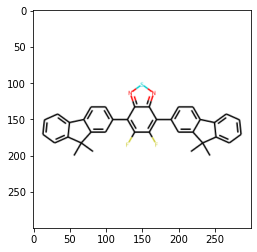

In [ ]:
sample_img = cv2.imread('./data/train_imgs/dev_2.png')
plt.imshow(sample_img)
plt.show()

In [7]:
device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 5
num_layers = 1
dropout_rate = 0.1
embedding_dim = 128
learning_rate = 1e-4
vision_pretrain = True
if not os.path.isdir('./models'):
  os.makedirs('./models')
save_path = f'./models/best_model.pt'

In [8]:
class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unique_char = sorted(list(unique_char))
        for i, char in enumerate(unique_char):
            self.txt2idx[char]=i+2
            self.idx2txt[i+2]=char
            
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)

In [9]:
max_len = train.SMILES.str.len().max()
max_len

265

In [12]:
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)

In [ ]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()
imgs = ('./data/train_imgs/'+train.uid+'.png').to_numpy()

100%|██████████| 30345/30345 [00:00<00:00, 78552.19it/s]


In [ ]:
from sklearn.utils import shuffle
imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)

In [ ]:
train_imgs = imgs[:27000]
train_seqs = seqs[:27000]
train_labels = labels[:27000]
val_imgs = imgs[27000:]
val_seqs = seqs[27000:]
val_labels = labels[27000:]

In [ ]:
train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

((27000,), (27000, 265), (27000, 2), (3345,), (3345, 265), (3345, 2))

In [20]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train'):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode=='train':
            self.labels = labels
            
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        if self.mode == 'train':
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
                'label' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'seq' : torch.tensor(self.seqs[i], dtype=torch.long),
            }

In [ ]:
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels)
val_dataset = CustomDataset(val_imgs, val_seqs, val_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_batch = next(iter(train_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size()

(torch.Size([64, 3, 300, 300]), torch.Size([64, 265]), torch.Size([64, 2]))

In [ ]:
sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype

(torch.float32, torch.int64, torch.float32)

In [13]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super(CNN_Encoder, self).__init__()
        model = models.resnet50(pretrained=vision_pretrain)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0,2,3,1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x

In [14]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super(RNN_Decoder, self).__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers)
        self.final_layer = nn.Linear((max_len+100)*embedding_dim, 2)

    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
        hidden, _ = self.lstm(embedded)
        hidden = hidden.view(hidden.size(0), -1)
        output = nn.ReLU()(self.final_layer(hidden))
        return output

In [15]:
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [16]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [17]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, seq)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
            loss = criterion(output, label)
            
        return loss

In [ ]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
422it [16:12,  2.30s/it, Epoch=1, Loss=0.162121, Total Loss=0.154178]
53it [00:48,  1.08it/s, Epoch=1, Val Loss=0.139874,

In [ ]:
torch.save(model, MODEL_DIR + 'best_model7_20.pt')

In [18]:
model = torch.load(MODEL_DIR + 'best_model7_20.pt')

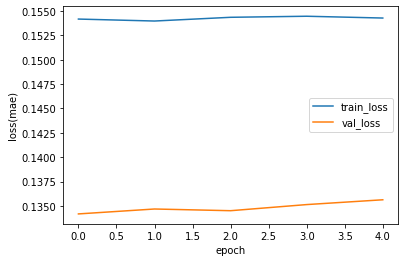

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

In [84]:
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [85]:
if not os.path.isdir('./data/test_imgs'):
  os.makedirs('./data/test_imgs')

for idx, row in tqdm(test.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'./data/test_imgs/{file}.png')

602it [00:10, 59.10it/s]


In [86]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = ('./data/test_imgs/'+test.uid+'.png').to_numpy()

100%|██████████| 602/602 [00:00<00:00, 46060.98it/s]


In [87]:
test_dataset = CustomDataset(imgs=test_imgs, seqs=test_seqs, labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [77]:
def predict(dataset):
    model.eval()
    # result = []
    result = np.array([[0, 0]])
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
        # gap = output[:, 0] - output[:, 1]
        # gap = np.where(gap<0, 0, gap)
        # result.extend(list(gap))
        result = np.append(result, output, axis=0)
        
    # return result
    return result[1:, :]

In [73]:
fin_train_seqs = tokenizer.txt2seq(train.SMILES)
fin_train_imgs = ('./data/train_imgs/'+train.uid+'.png').to_numpy()

fin_train_dataset = CustomDataset(imgs=fin_train_imgs, seqs=fin_train_seqs, labels=None, mode='test')
fin_train_dataloader = torch.utils.data.DataLoader(fin_train_dataset, batch_size=BATCH_SIZE, num_workers=16)

100%|██████████| 30345/30345 [00:00<00:00, 53266.84it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [78]:
# for trainset
pred = predict(fin_train_dataloader)
# train['base_prediction'] = pred

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


array([[4.77943563, 3.33163452],
       [3.81846547, 3.48391032],
       [3.65370321, 3.06386971],
       ...,
       [2.38546991, 2.11298251],
       [2.64740539, 2.71112466],
       [2.60808849, 2.60947442]])

In [81]:
train['base_S1'] = pred[:, 0]
train['base_T1'] = pred[:, 1]
train

,uid,SMILES,S1_energy(eV),T1_energy(eV),base_S1,base_T1
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,4.779436,3.331635
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,3.818465,3.483910
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,3.653703,3.063870
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,4.960636,3.675034
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,6.645788,6.362556
...,...,...,...,...,...,...
66,dev_66,N#Cc1cc(-c2ccc(N3c4ccccc4Oc4ccccc43)cc2)c(-c2c...,2.1939,2.1846,2.258025,2.301998
67,dev_67,CC1(C)c2ccccc2N(c2ccc(-c3nc4ccc(N5c6ccccc6C(C)...,2.3537,2.3371,2.784769,2.693157
68,dev_68,Cc1cc(-n2c3ccc(C(C)(C)C)cc3c3cc(C(C)(C)C)ccc32...,2.1364,2.1260,2.385470,2.112983
69,dev_69,Cc1cc(-n2c3ccccc3c3ccccc32)cc(C)c1B1c2ccccc2B(...,2.2650,2.2511,2.647405,2.711125


In [83]:
train.to_csv(MY_PATH + 'base_prediction3.csv', index=False)

In [90]:
# for testset
pred = predict(test_dataloader)
test['base_S1'] = pred[:, 0]
test['base_T1'] = pred[:, 1]
# submission['ST1_GAP(eV)'] = pred

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [91]:
test

,uid,SMILES,base_S1,base_T1
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C,4.654011,3.853164
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...,6.663556,4.177497
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...,3.719763,2.717198
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...,4.305375,3.658068
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...,4.734657,3.339833
...,...,...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...,2.660511,2.637302
598,test_598,CC1(C)c2ccccc2N(c2ccc(-c3cc(-c4ccc(N5c6ccccc6C...,2.967572,2.746269
599,test_599,Cc1nc(-c2ccc(N3c4ccccc4C(C)(C)c4ccccc43)cc2)cc...,3.390600,3.007870
600,test_600,c1ccc2c(c1)Oc1ccccc1N2c1ccc(-c2nc3ccccc3s2)cc1,3.357671,2.804271


In [89]:
# submission

In [92]:
# submission.to_csv(SUBMISSION_DIR + 'dacon_baseline5.csv', index=False)
test.to_csv(SUBMISSION_DIR + 'dacon_baseline5.csv', index=False)